# Sarima

In [12]:
import pandas as pd
import time
from itertools import combinations, product
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression
import warnings
from tqdm import tqdm

In [10]:
def rmse(y_pred, y_true):
    MSE = mean_squared_error(y_true, y_pred)
    return math.sqrt(MSE)

def plot_sortie_acf( y_acf, y_len, pacf=False):
    "représentation de la sortie ACF"
    if pacf:
        y_acf = y_acf[1:]
    plt.figure(figsize=(14,2))
    plt.bar(range(len(y_acf)), y_acf, width = 0.1)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.show()
    return

In [4]:
whole_df = pd.read_csv("/Users/cha/Desktop/Code/eCSpress/data/bdd_finale.csv")
whole_df['Date et heure de comptage'] = pd.to_datetime(whole_df['Date et heure de comptage'], format='%Y-%m-%d %H:%M:%S')
print("len whole_df", len(whole_df))
whole_df.columns

len whole_df 27548


Index(['Libelle', 'Date et heure de comptage', 'Débit horaire',
       'Taux d'occupation', 'Etat trafic', 'Etat arc_Barré',
       'Etat arc_Invalide', 'Jour férié', 'Jour de la semaine_0',
       'Jour de la semaine_1', 'Jour de la semaine_2', 'Jour de la semaine_3',
       'Jour de la semaine_4', 'Jour de la semaine_5', 'Jour de la semaine_6',
       'maxtempC', 'mintempC', 'avgtempC', 'totalSnow_cm', 'uvIndex', 'tempC',
       'windspeedKmph', 'winddirDegree', 'weatherCode', 'precipMM', 'humidity',
       'visibility', 'pressure', 'cloudcover', 'HeatIndexC', 'DewPointC',
       'WindChillC', 'WindGustKmph', 'FeelsLikeC', 'is_day', 'paris_repsire',
       'perturbation_travaux'],
      dtype='object')

## Champs Elysees

In [5]:
libelle = "AV_Champs_Elysees"
variable = 'Débit horaire'

ce_df = whole_df[whole_df["Libelle"]==libelle]
print("nb instances", len(ce_df))
ce_df = ce_df.sort_values(by='Date et heure de comptage')
ce_df = ce_df.reset_index(drop=True)
ce_df = ce_df.set_index('Date et heure de comptage')
ce_df = ce_df.asfreq('H', method= 'ffill')
ce_df['Lag_7'] = ce_df['Débit horaire'].shift(168)
ce_df.head()

nb instances 9186


,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Etat arc_Barré,Etat arc_Invalide,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,...,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,is_day,paris_repsire,perturbation_travaux,Lag_7
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2021-11-01 04:00:00,AV_Champs_Elysees,1222.0,42.87945,3,0,1,1,1,0,0,...,29,10,7,8,28,8,False,False,0.0,NaN
2021-11-01 05:00:00,AV_Champs_Elysees,1033.0,44.35278,3,0,1,1,1,0,0,...,36,10,7,8,28,8,False,False,0.0,NaN
2021-11-01 06:00:00,AV_Champs_Elysees,824.0,20.16222,2,0,1,1,1,0,0,...,43,11,7,8,28,8,False,False,0.0,NaN
2021-11-01 07:00:00,AV_Champs_Elysees,710.0,12.20000,1,0,1,1,1,0,0,...,32,10,6,8,27,8,False,False,0.0,NaN
2021-11-01 08:00:00,AV_Champs_Elysees,947.0,40.57222,3,0,1,1,1,0,0,...,21,10,6,8,25,8,True,False,0.0,NaN


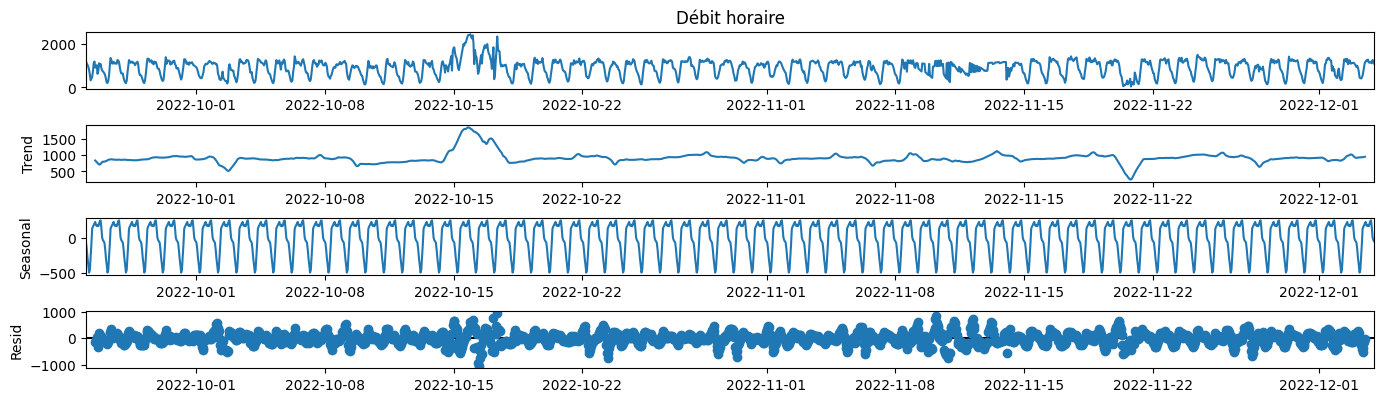

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = ce_df[variable][-7*24*10:]
decomp_x = seasonal_decompose(df, model='additive') #, period=24*7)
fig = decomp_x.plot()
fig.set_size_inches(16, 4)
plt.show()

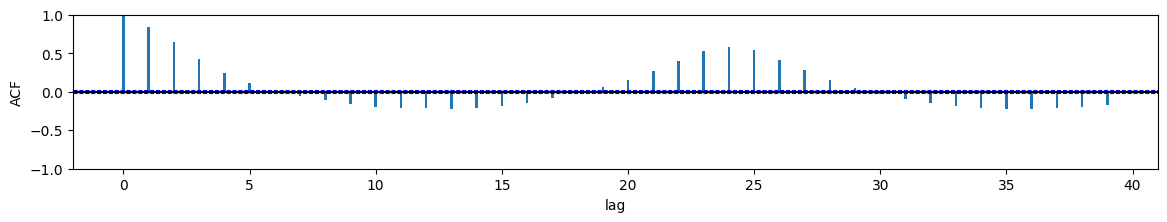

In [13]:
y = np.log(ce_df[variable])
y_len = len(y) # variable nécessaire pour l'utilisation de plot_sortie_acf
plot_sortie_acf(acf(np.asarray(y)), y_len)

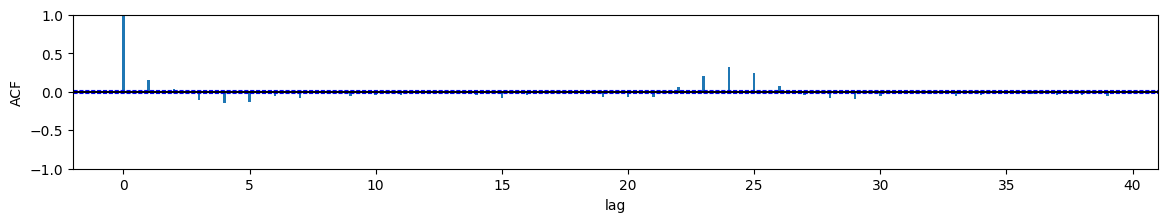

In [16]:
y_dif1 = y - y.shift(1)

plot_sortie_acf(acf(np.asarray(y_dif1[1:])), y_len)

In [ ]:
# Ordres du modèle
p,q,d=2,1,4
seasonal = (2,1,4,24)

# Création des dates nécessaires
a = datetime.strptime('2020-11-23 00:00:00', '%Y-%m-%d %H:%M:%S')
b = datetime.strptime('2020-11-27 23:00:00', '%Y-%m-%d %H:%M:%S')
X_train = create_df(df_ACE).loc['2020-11-01':'2020-11-22'].debit
X_test = create_df(df_ACE_test).loc['2020-11-23':'2020-11-27'].debit

fitting = True
if fitting:
    s = time.time()
    mod = sm.tsa.statespace.SARIMAX(X_train,order=(p,q,d),seasonal_order=seasonal,enforce_stationarity=False,enforce_invertibility=False)
    model = mod.fit()
    pred = model.predict(start=a,end=b)
    e = time.time()
    print(f"Temps d'éxecution: {e-s}")
    rmse = round(np.sqrt(mean_squared_error(X_test, pred)),1)
    plt.plot(X_train, label='Données')
    plt.plot(X_test, "--",  label='Target')
    plt.plot(pred, label='Prediction')
    plt.xticks(rotation=45)
    plt.title(f'Predictions pour Champs Élysées du 22 au 27 Novembre 2020 \n RMSE={rmse}')
    plt.legend()
    plt.show()


In [10]:
class ForecastingSARIMA:
    def __init__(self, df):
        self.df = df
        self.best_sarima_model_config = None
        self.best_sarima_fitted_model = None

    def forecast(self):
        self.getBestConfigSarima()
        self.fitBestModel()
        RMSE = self.evaluate_pred()
        return RMSE
 

    def getBestConfigSarima(self):
        """
        Function that returns the best configuration for a SARIMA model
        """
        p = q = range(0, 2)
        d = [0, 1]
        pdq = list(product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 30) for x in pdq]

        current_best_config = None
        current_best_aic = None
        for order in pdq:
            for seasonal_order in seasonal_pdq:
                try:
                    model = sm.tsa.statespace.SARIMAX(
                        self.df.iloc[len(self.df)-180 : len(self.df)-120],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_invertibility=False,
                        enforce_stationarity=False
                    )

                    results = model.fit(disp=False)
                    results_aic = results.aic
                    if not current_best_aic or results_aic < current_best_aic:
                        current_best_aic = results_aic
                        current_best_config = (order, seasonal_order)
                except ValueError:
                    continue

        self.best_sarima_model_config = current_best_config


    def fitBestModel(self):
        """
        Function that returns the best SARIMA fitted model.
        """
        model = sm.tsa.statespace.SARIMAX(
            self.df.iloc[len(self.df)-180 : len(self.df)-120],
            order = self.best_sarima_model_config[0],
            seasonal_order=self.best_sarima_model_config[1],
            enforce_invertibility=False,
            enforce_stationarity=False
        )

        self.best_sarima_fitted_model = model.fit(disp=False)
    
    
    def evaluate_pred(self):
        """
        Function that plots the SARIMA prediction with the best fitted model.
        """
        pred = self.best_sarima_fitted_model.get_forecast(steps=7*24)
        pred_ci = pred.conf_int()
        pred_mean = pred.predicted_mean
        pred_mean = pred_mean.rename("Stock")

        self.df = self.df.squeeze()
        RMSE = round((np.sqrt((self.df.iloc[len(self.df)-119 : len(self.df)] - pred_mean)**2)).mean(),2)

        print(f"RMSE error : {RMSE}")

        ax = df.plot(label='Valeur réelle')
        pred_mean.plot(ax = ax, label='Valeur prédite')

        ax.fill_between(
            pred_ci.index,
            pred_ci.iloc[:,0],
            pred_ci.iloc[:,1],
            color='k',
            alpha=0.2
        )

        plt.xlabel('Date')
        plt.ylabel('Nombre de délégations')
        plt.legend()
        plt.show()

        return RMSE


In [13]:
# warnings.filterwarnings("ignore")

sarima = ForecastingSARIMA(ce_df)
RMSE = sarima.forecast()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
plot(acf(y,lag.max=36,plot=FALSE),ylim=c(-1,1))